## Analysis of stock prices using PCA / Notebook 3

In this notebook we will study the dimensionality of stock price sequences, and show that they lie between the 1D of smooth functions and 2D of rapidly varying functions.

The mathematicians Manuel Mandelbrot and Richard Hudson wrote a book titled [The Misbehavior of Markets: A Fractal View of Financial Turbulence](https://www.amazon.com/gp/product/0465043577?ie=UTF8&tag=trivisonno-20&linkCode=as2&camp=1789&creative=9325&creativeASIN=0465043577).  In this book they demonstrate that financial sequences have a fractal dimension that is higher than one. In other words, the changes in stock prices are more similar to random walk, than to a smooth differentiable curve.

In this notebook we will estimate the fractal dimension of sequences corresponding to the log of the price of a stock. We will do the same for some other, non-random sequences.

We will use the [Box Counting](https://en.wikipedia.org/wiki/Box_counting) method to estimate the dimension.

### Box Counting
For the sake of simplicity, lets start with a simple smooth curve corresoinding to $sin(x)$.
Intuitively speaking, the dimension of this curve should be 1. Lets see how we measure that using box-counting.

The idea is simple: we split the 2D plane into smaller and smaller rectangles and count the number of rectangles that touch the curve.  The gridlines in the figure below partition the figure into $16 \times 16 = 256$ rectangles. The yellow shading corresponds the partition of the figure into $8 \times 8$ rectangles. The green corresponds to the partition into $16\times 16$ (which is the same as the grid), The blue and the red correspond to partitions into $32\times32$ and $64 \times 64$ respectively. You can see that as theboxes get smaller their number increases. 

![Sinusoid](figs/Sinusoid.BoxCount.png)

The dimension is defined by the relation between the size of the cubes and the number of rectangle that touch the curve. More precisly, we say that the size of a rectangle in a $n \times n$ partition is $\epsilon=1/n$. We denote by $N(\epsilon)$ the number of rectangles of size $\epsilon$ that touch the curve. Then if $d$ is the dimension, the relationship between $N(\epsilon)$ and $\epsilon$ is 
$$
N(\epsilon) = \frac{C}{\epsilon^d}
$$
For some constant $C$

Taking $\log$s of both side we get 
$$
(1)\;\;\;\;\;\;\;\;\;\;\;\;\log N(\epsilon) = \log C + d \log \frac{1}{\epsilon}
$$

We can use this equation to estimate $d$ as follows: let $\epsilon_2 \gg \epsilon_1$ be two sizes that are far apart (say $\epsilon_1=1/4$ and $\epsilon_2=1/1024$), and let $N(\epsilon_1),N(\epsilon_2)$ be the corresponding box counts. Then by taking the difference between Equation (1) for the two sizes we get the estimate
$$
    d \approx \frac{\log N(\epsilon_1) - \log N(\epsilon_2)}{\log \epsilon_2- \log \epsilon_1}
$$

Note that this is an estimate, it depends on the particular values of $\epsilon_1$ and $\epsilon_2$. We can refer to it as the "dimension" if we get the same number for any choice of the two sizes (as well as other details sich as the extent of the function.

Here are similar figures for the seque 
![AMZN](figs/AMZN.BoxCount.png)

![IBM](figs/IBM.BoxCount.png)		

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[3]")

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline

import numpy as np


Populating the interactive namespace from numpy and matplotlib


In [2]:
df=sqlContext.read.csv('SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [3]:
columns=df.columns
col=[c for c in columns if '_P' in c]
tickers=[a[:-2] for a in col]
tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG'], 476)

In [4]:
def get_seq(ticker):
    key=ticker+"_P"
    L=df.select(key).collect()
    L=[x[key] for x in L if not x[key] is None]
    return L

#### You can generate graphs like the ones below for your analysis of dimensionality on the stocks (recommended but not graded)
![Graph for Analysing Stocks](figs/plots.png)

In [5]:
pickleFile="Tester/Dimensionality.pkl"

##  Exercise 1 -- Finding Dimension


In this exercise, you will do the following:
    * You will find the dimension for a particular ticker using its sequence of data

######  <span style="color:blue">Sample Input:</span>
```python
  
dimension = Box_count([sequence of AAPL], 'AAPL')

```
######  <span style="color:magenta">Sample Output:</span>
dimension = 1.28

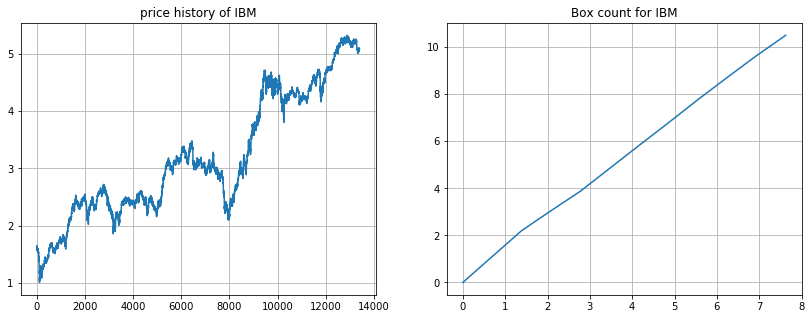

1.2416533660199585

In [14]:
# Method to find out the dimensionality of the sequence of a ticker
def box_count_sequence(LL,ticker):
    ## Your Implementation goes here
    #from scipy.stats import linregress

    dimension = 0.0
    len_x = len(LL)
    min_y,max_y = min(LL),max(LL)
    len_y = max_y - min_y
    box_counts = []
    max_n = int(math.log(len_x,2)) - 1
    epsilons = []
    
    for j in range(max_n):
        n = pow(2,j)
        epsilons.append(n)
        box_count = 0
        segment_x, segment_y = 1.0*len_x/n, 1.0*len_y/n
        for i in range(n):
            seg_start = int(i * segment_x)
            seg_end = int((i+1) * segment_x) 
            y = LL[seg_start:seg_end]
            min_y1, max_y1 = min(y), max(y)
            box_start = floor((min_y1 - min_y) / segment_y)
            box_end = ceil((max_y1 - min_y) / segment_y)
            box_count += (box_end - box_start)
            #print i,box_start,box_end,box_count
        box_counts.append(box_count)

    return (epsilons,box_counts)
    
def Box_count(LL,ticker):
    ## Your Implementation goes here
    #from scipy.stats import linregress
    epsilons,box_counts = box_count_sequence(LL, ticker)

    #dimension = linregress(np.log(epsilons),np.log(box_counts)).slope
    dimension = (np.log(box_counts[-1]) - np.log(box_counts[1])) / (np.log(epsilons[-1]) - np.log(epsilons[1]))
    return dimension

prices = get_seq('IBM')
epsilons,box_counts = box_count_sequence(prices, 'IBM')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title('price history of IBM')
plt.grid()
plt.plot(np.log(prices))
plt.subplot(1,2,2)
plt.title('Box count for IBM')
plt.plot(np.log(epsilons),np.log(box_counts))
plt.grid()
plt.show()

aapl = get_seq('AAPL')
Box_count(aapl, 'AAPL')


### Test Cases for Finding Dimension

In [15]:
import Tester.Dimensionality as Dimensionality
Dimensionality.exercise_1(pickleFile, Box_count)

Input: sequence 1
Correct Output: 0.988354081412
Great Job!



In [16]:
import Tester.Dimensionality as Dimensionality
Dimensionality.exercise_2(pickleFile, Box_count)

Input: sequence 2
Correct Output: 1.98760591825
Great Job!



In [17]:
import Tester.Dimensionality as Dimensionality
Dimensionality.exercise_3(pickleFile, Box_count)

Input: sequence 3
Correct Output: 1.34156643681
Great Job!

